# Etapa 3, 4 e 5 - preparação dos dados, modelagem e validação + teste dos modelos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pwd

/content


#### Não podemos separar a etapa de preparação dos dados sem levar em conta a modelagem que iremos utilizar, eu irei utilizar como modelo o random forest, gradient boosted trees e regressão binária com função de ligação assimétrica.

#### Para a modelagem eu irei utilizar a regressão binária com função de ligação assimétrica, um erro muito comum em tarefas de classificação é utilizar a regressão logística que é um modelo linear generalizado com função de ligação simétrica para classificar dados desbalanceados, quando se trata de dados desbalanceados no contexto de classificação a literatura recomenda o uso de funções de ligação assimétrica no caso de se usar um modelo linear generalizado. Para entender em detalhes esse conceito você pode ler meu artigo [onde explico sobre regressão com função de ligação assimétrica](https://medium.com/@gabrielbbr/o-que-%C3%A9-regress%C3%A3o-bin%C3%A1ria-com-fun%C3%A7%C3%A3o-de-liga%C3%A7%C3%A3o-assim%C3%A9trica-fb53c51c42a1), mas resumindo nos modelos lineares generalizados temos uma componente que se chama função de ligação que é uma função que transforma dados do conjunto dos reais para o intervalo [ 0, 1 ], e essas funções são equivalentes as funções de probabilidade acumulada (F.D.A) e o valor que esses modelos prevêem é igual a probabilidade de uma classe, ou seja, se temos dados com distribuição desbalanceada naturalmente faz sentido pensar que uma F.D.A. que represente a probabilidade de ocorrência dessas classes desbalanceadas seja assimétrica, e temos diversos estudos de comparação de modelos em dados debalanceados comparando funções de ligação simétrica com assimétrica em dados desbalanaceados comprovando que esse raciocínio é verdadeiro na prática na maioria das vezes.

#### Uma informação importante relacionada a regressão que podemos retirar da literatura é que o efeito da padronização nas variáveis numéricas pode piorar a performance da regressão, ou melhorar ou não fazer diferença, isso depende do método de estimação adotado na regressão, no meu caso irei utilizar métodos bayesianos além de métodos clássicos então em um primeiro momento não irei padronizar as variáveis numéricas por conta disso, além disso os métodos random forest e gradient boosted trees são baseados em árvores e invariantes a mudanças na escala das variáveis numéricas.

#### Como comentado no final do notebook de introdução, alguns autores argumentam que devemos considerar uma variável categórica ordinal como ordinal caso ela possua relação de ordinalidade com a variável resposta, e não em relação ao seu significado inerente, com isso em mente e com o nosso entendimento dos dados podemos aplicar uma transformação ordinal na variável de grau do empréstimo (loan_grade), na variável do tipo de residência do cliente (person_home_ownership) podemos aplicar a mesma transformação por conta do raciocínio de relação ordinal com a variável resposta, e na variável que indica se a pessoa já foi inadimplente ou não (cb_person_default_on_file) que é uma variável dicotômica, na variável que indica a intenção do empréstimo (loan_intent) podemos aplicar one-hot-encoding onde transformamos cada categoria numa coluna dicotômica que indica a presença ou ausência da categoria, as variáveis loan_intent e loan_grade apresentam uma cardinalidade média, caso o modelo não performe muito bem podemos tentar reduzir o número de classes dentro dessa variável para melhorar a acurácia do modelo no momento da modelagem.

#### Além disso faremos o preprocessamento após a divisão de treino e teste, neste caso não faz diferença pois não teremos funções de transformação que dependem do tamanho da amostra, mas é seguido esse método apenas por costume.

In [1]:
! pip install pystan
! pip install ks_metric
! pip install nest_asyncio
! pip install imblearn
! pip install statsmodels
! pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.5/239.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 531.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.3/124.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.6/301.6 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 481.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190

In [2]:
# manipular dados
import pandas as pd
import numpy as np

# feature selection/ selecao de variaveis
from sklearn.feature_selection import mutual_info_classif

# dados faltantes
from sklearn.linear_model import LinearRegression

# algumas visualizações
import matplotlib.pyplot as plt
from matplotlib import cm
cmap = cm.get_cmap('Dark2')
from pandas.plotting import parallel_coordinates

# validar e ajustar os modelos
from scipy import stats
import ks_metric as ks
from sklearn.metrics import f1_score
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score, make_scorer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
kappa_scorer = make_scorer(cohen_kappa_score)

# modelos
import statsmodels.api as sm
import stan
import nest_asyncio
nest_asyncio.apply()
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# optimização hiperparametros
from sklearn.model_selection import GridSearchCV

# salvar modelos, manipulacoes de objetos salve
import pickle
import os
import copy

<ipython-input-2-b77cb74b7adf>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Dark2')


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/remake_projeto_credito/dados/df_sem_na.csv')

In [ ]:
y = df['loan_status']
X = df.drop( columns = ['loan_status', 'Unnamed: 0.1', 'Unnamed: 0'], axis = 1 )

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0, stratify = y)

#### Embora muitas pessoas utilizem o pipeline do skelarn para criar o preprocessamento eu prefiro utilizar funções personalizadas, porque acho mais fácil de serem manipuladas e dar manutenção, podem ser transformadas em pacotes personalizados para cada conjunto de dados que posso vir a utilizar, tornando o compartilhamento dessas ferramentas de preprocessamento mais fácil entre os times. Mas é uma questão de opção pessoal e respeito as outras alternativas.

In [ ]:
# colunas
ordinal = ['loan_grade', 'person_home_ownership', 'cb_person_default_on_file']
one_hot = ['loan_intent']
colunas = X.columns
colunas_numericas = [i not in ordinal or one_hot for i in colunas]

In [ ]:
ordinal_cols ={
'loan_grade' : {'A': 1, 'B': 2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7},
'person_home_ownership' : {'OTHER':1, 'OWN':2, 'RENT':3, 'MORTGAGE':4},
'cb_person_default_on_file' : {'Y':1, 'N':2}
}

In [ ]:
# transformar colunas ordinais
def transform_ordinal( df : pd.DataFrame, dict_labels : dict):

    df = df.replace(dict_labels)
    colunas = list(dict_labels.keys())
    df[colunas] = df[colunas].astype(int)
    return df

# transformar colunas one hot encoding
def transforma_one_hot( df : pd.DataFrame, cols : list ):

    return pd.get_dummies(df, columns = cols, dtype = int)

def substitute_loan_int_rate(int_rate_p_grade, row ):

  if pd.isna(row['loan_int_rate']):

    grade = row['loan_grade']
    mean_int_rate = int_rate_p_grade.loc[int_rate_p_grade['loan_grade']==grade, 'loan_int_rate']
    row['loan_int_rate'] = mean_int_rate

  else:
    row = row

  return row


def substitui_dados_faltantes( X_train_val_test : pd.DataFrame ):

  print(X_train_val_test['person_emp_length'].isna().sum())

  if X_train_val_test['person_emp_length'].isna().sum() != 0:

    X = pd.DataFrame(X_train_val_test['person_age'])
    indices_treino = X_train_val_test['person_emp_length'].dropna().index

    X = pd.DataFrame( X_train_val_test.loc[indices_treino, 'person_age'] )
    y = pd.DataFrame( X_train_val_test.loc[indices_treino, 'person_emp_length'] )
    reg = LinearRegression().fit(X, y)

    indices_pred = X_train_val_test[X_train_val_test['person_emp_length'].isna()].index
    valores_prever = pd.DataFrame(X_train_val_test.loc[indices_pred, 'person_age'])

    X_train_val_test.loc[indices_pred, 'person_emp_length'] = reg.predict(valores_prever)

  if X_train_val_test['loan_int_rate'].isna().sum() != 0:

    int_rate_p_grade = X_train_val_test.groupby('loan_grade')['loan_int_rate'].mean().reset_index()
    df_na = X_train_val_test[ X_train_val_test['loan_int_rate'].isnull() ]
    df_na = df_na.apply(lambda x: substitute_loan_int_rate(int_rate_p_grade,x),axis=1)
    X_train_val_test.loc[ df_na.index ] = df_na

  return X_train_val_test

In [ ]:
X_train = transform_ordinal(X_train, ordinal_cols)
X_train = transforma_one_hot(X_train, one_hot)
X_train = substitui_dados_faltantes(X_train)
X_train = X_train.reset_index(drop = True)

#### Para validação será utilizado o método de k-fold estratificado de acordo com a variável resposta, que será dividido em três parte, treino, validação e teste. O treino irá ajustar o modelo, o conjunto de validação será utilizado para ajustar os hiperparâmetros e o conjunto de teste para avaliar o modelo.

#### Antes de fazer os conjuntos k-fold as funções para fazer ajuste dos modelos, e cálculo de métricas são definidas

## Vamos calcular alguma métricas importantes para o negócio, como o lucro médio dos não inadimplentes, o faturamento médio de um não inadimplente, o gasto médio de um inadimplentes, o faturamento e lucro final sem utilizar modelos.

#### Como vimos na etapa de entendimento dos dados o grupo de não inadimplentes e inadimplentes possuem diferenças na distribuição da quantidade do empréstimo, e nas taxas de cada empréstimo, então vamos calcular as métricas considerando esses grupos.

In [ ]:
def faturamento_total(df, target):
  '''
  operações com matrizes são mais rápidas, por isso optei por criar
  colunas como indicativos
  '''

  df['montante_final'] = df['loan_amnt'] * (1 + df['loan_int_rate']/100)
  df['indicativo'] = df['montante_final']*df[target] #
  df['indicativo'] = (-1)*df['indicativo']
  faturamento_final = df['montante_final'].sum() + df['indicativo'].sum()

  df['loan_amnt_nao_inad'] = df[target].replace( {0:1, 1:0} )
  df['loan_amnt_nao_inad'] = df['loan_amnt_nao_inad']*df['loan_amnt']
  lucro_final = df['montante_final'].sum() + df['indicativo'].sum() - df['loan_amnt_nao_inad'].sum()
  gasto_total = (-1)*df['indicativo'].sum() + df['loan_amnt_nao_inad'].sum()

  df = df.drop( columns=['indicativo', 'montante_final', 'loan_amnt_nao_inad'], axis=1 )

  return faturamento_final, lucro_final,gasto_total

# faturamento e lucro total

In [ ]:
faturamento_total, lucro_total, gasto_total = faturamento_total(df, 'loan_status')
print('Sem utilizar modelo')
print('faturamento total', faturamento_total, 'lucro total', lucro_total,
      'gasto total', gasto_total)

Sem utilizar modelo
faturamento total 156361392.77701938 lucro total 15115592.777019382 gasto total 193688429.71052217


## lucro médio dos não inadimplentes

In [ ]:
n_inad = df.loc[ df['loan_status']==0 ]
taxa_porcentagem = n_inad['loan_int_rate']/100 # o valor do emprestimo X taxa
total = n_inad['loan_amnt']*taxa_porcentagem # valor da taxa em cima do montante
lucro_medio_cliente_n_inad = total.sum()/len(total)
print('Em média é gerado um lucro de R$',lucro_medio_cliente_n_inad,'por cliente não inadimplente')

Em média é gerado um lucro de R$ 989.0461805286513 por cliente não inadimplente


lembrando que isso se soma ao dinheiro em caixa que foi emprestado ao clinete, então se considerarmos o dinheiro em caixa como um gasto e calcularmos o faturamento teríamos

In [ ]:
# Faturamento médio de uma não inadimplente
n_inad = df.loc[ df['loan_status']==0 ]
taxa_porcentagem = n_inad['loan_int_rate']/100 # o valor do emprestimo X taxa
total = n_inad['loan_amnt']*taxa_porcentagem
faturamento_medio_cliente_n_inad = total.sum()/len(total) + n_inad['loan_amnt'].mean()
print('Em média é gerado um faturamento de R$',faturamento_medio_cliente_n_inad,'por cliente não inadimplente')
print('Quantidade Média de um empréstimo dos cliente não inadimplentes', n_inad['loan_amnt'].mean())

Em média é gerado um faturamento de R$ 10231.066726233028 por cliente não inadimplente
Quantidade Média de um empréstimo dos cliente não inadimplentes 9242.020545704378


Ou seja é gerado um faturamento de $\sim$ R$ 10231 por cliente não inadimplente, agora vamos calcular o gasto médio de um inadimplente, considerando a quantidade de dinheiro emprestada mais a taxa que foi combinada ao emprestar o dinheiro.

In [ ]:
inad = df.loc[ df['loan_status']==1 ]
taxa_porcentagem = inad['loan_int_rate']/100 # o valor do emprestimo X taxa
total = inad['loan_amnt']*taxa_porcentagem
total = total.sum()
total = total + inad['loan_amnt'].mean()
gasto_medio_inadimplente = total/inad.shape[0]
print('em média é gerado um gasto de R$',gasto_medio_inadimplente,'por cliente inadimplente')
print('média da quantidade dos empréstimos dos inadimplentes',inad['loan_amnt'].mean())

em média é gerado um gasto de R$ 1436.8151199546533 por cliente inadimplente
média da quantidade dos empréstimos dos inadimplentes 10861.776084407971


Esse é o gasto médio de um inadimplente

In [ ]:
gasto_inadimplente = 1436.8151199546533
faturamento_medio_cliente_n_inad = 10231.066726233028
lucro_medio_cliente_n_inad = 989.0461805286513

## No momento da classificação vamos considerar que um falso positivo cause um gasto igual a média de lucro por cliente igual a R$989.0461805286513 pois perdemos a oportunidade.

## Um Falso negativo causa o gasto de um inadimplente, pois é um inadimplente R$1436.8151199546533

## O bom pagador causa um lucro de 989.0461805286513
## e um verdadeiro negativo não causa gasto nenhum nem lucro nenhum.


# Antes de fazer o ajuste dos modelos é importante verificar a importância das variáveis para prever a variável resposta
#### Para isso é utilizado o critério mutual information que verifica a importância tanto das variáveis numéricas quanto das variáveis  categóricas e cria um ranking


In [ ]:
X_train = transform_ordinal(X_train, ordinal_cols)
X_train = transforma_one_hot(X_train, one_hot)
X_train = X_train.reset_index(drop = True)

<Axes: >

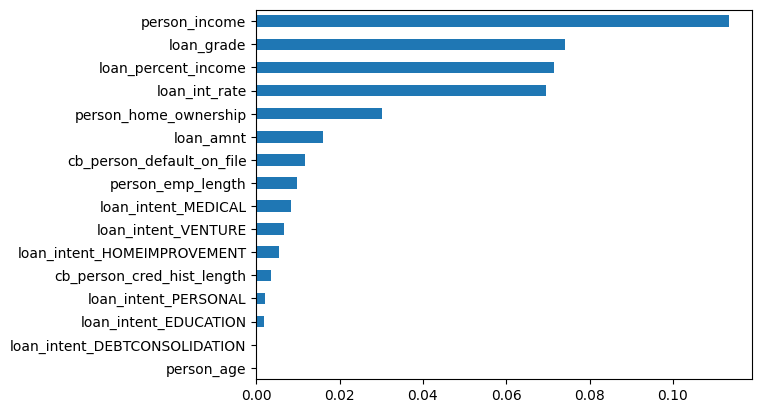

In [ ]:
# Assuming df is your DataFrame and target is your target variable
mi = mutual_info_classif(X_train, y_train)

# Select top features based on mutual information
# top_features = np.argsort(mi)[-:]  # select top 10 features
top_features = pd.Series(mi, index=X_train.columns).sort_values(ascending=True)
top_features.plot(kind='barh')

A idade agraga pouca informação em relação a variável resposta, mas como já vimos ela foi usada para prever o tempo de empregamento, a variável person_emp_length que tem maior importância, então podemos retirar essa variável e ver o efeito nos modelos. Vamos testar os modelos com todas as variáveis, depois retirando as variáveis com score de importância menor do que 0.02, e depois menores do que 0.04.

#### métricas de validação

In [ ]:
def convert_to_classes(probs, threshold=0.5):
    """
    Convert probabilities to classes based on a threshold.

    Parameters:
    probs : array-like
        Array of predicted probabilities
    threshold : float, optional (default=0.5)
        Threshold for class assignment

    Returns:
    classes : array-like
        Array of predicted classes (0 or 1)
    """
    return np.where(probs >= threshold, 1, 0)

def calculate_ks(y_true, y_prob):
    """
    Calculate Kolmogorov-Smirnov (KS) metric.

    Parameters:
    y_true : array-like
        True binary labels
    y_prob : array-like
        Predicted probabilities for positive class

    Returns:
    ks : float
        KS metric value
    """
    ks_ = ks.ks_score(y_true, y_prob)
    return ks_/100

def calculate_mcc(y_true, y_pred):
    """
    Calculate Matthews correlation coefficient (MCC).

    Parameters:
    y_true : array-like
        True binary labels
    y_pred : array-like
        Predicted binary labels

    Returns:
    mcc : float
        Matthews correlation coefficient value
    """
    return matthews_corrcoef(y_true, y_pred)

def calculate_kappa(y_true, y_pred):
    """
    Calculate Cohen's kappa coefficient.

    Parameters:
    y_true : array-like
        True binary labels
    y_pred : array-like
        Predicted binary labels

    Returns:
    kappa : float
        Cohen's kappa coefficient value
    """
    return cohen_kappa_score(y_true, y_pred)

def calculate_f1_score(y_true, y_pred):
    """
    Calculate F1 score.

    Parameters:
    y_true : array-like
        True binary labels
    y_pred : array-like
        Predicted binary labels

    Returns:
    f1 : float
        F1 score value
    """
    return f1_score(y_true, y_pred)

def calculate_g_mean(y_true, y_pred):
    """
    Calculate G-mean.

    Parameters:
    y_true : array-like
        True binary labels
    y_pred : array-like
        Predicted binary labels

    Returns:
    g_mean : float
        G-mean value
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    print('sensitivity', sensitivity, 'specificity', specificity)
    return np.sqrt(sensitivity * specificity)

#### Ajuste de modelos de regressão

In [ ]:
def binary_regression(X, y, link_='logit'):
    """
    Perform binary regression using specified link function.

    Parameters:
    X : array-like
        Feature matrix
    y : array-like
        Target vector
    link : {'logit', 'probit', 'cloglog', 'log', 'identity', 'inverse_power'}
        Link function for the model

    Returns:
    model : statsmodels.genmod.generalized_linear_model.GLM
        Fitted binary regression model
    """
    if link_ not in ['cloglog', 'loglog']: # tirei logc
        raise ValueError("Invalid link function. Choose from ['cloglog','loglog']")

    X = sm.add_constant(X)
    link_str = f"sm.families.links.{link_}()"

    model = sm.GLM(y, X, family=sm.families.Binomial(link = eval(link_str)))

    return model


In [ ]:
def fit_all_links(X_train, y_train):
    """
    ajusta todos os modelos de regressão binária assimétrica disponíveis na
    biblioteca stats

    Parameters:
    X_train : array-like
        matriz de treino
    y_train : array-like
        vetor resposta de treino

    Returns:
    models : dicta
        dicionário contendo o modelo ajustado com o modelo como chave
    """

    models = {}
    link_functions = ['cloglog', 'loglog']

    for lk in link_functions:
        model = binary_regression(X_train, y_train, link_=lk)

        try:
          models[lk] = model.fit()

        except:
          print(lk)

    return models


In [ ]:
def predict_all_models(models, X_test):
    """
    Faz previsão para cada modelo de reg. binária

    Parameters:
    models : dict
        dicionário contendo as regressões treinadas
    X_test : array-like
        matriz de teste

    Returns:
    predictions : dict
        dicionario contendo as predições para cada modelo.
    """
    predictions = {}

    for link, model in models.items():
        X_test_with_const = sm.add_constant(X_test)
        y_pred_prob = model.predict(X_test_with_const)
        predictions[link] = y_pred_prob

    return predictions


In [ ]:
def reg_pred_validation_test( modelos, X_validation, X_test ):
  '''
  faz predições na validação e teste

  retorna dicionario com as predições, chave ligacao

  '''

  predicions = predict_all_models( modelos, X_validation )
  predicions_teste = predict_all_models( modelos, X_test )

  return predicions, predicions_teste


In [ ]:
def metrics_hat_thr( thrs, y_test, ligs_test, modelos ):
  '''
  calcular as métricas do modelo, após estimar a regra de
  '''

  metricas = pd.DataFrame(0, index = np.arange(2),columns=['ks', 'f1_score', 'g_mean','kappa', 'mcc'])
  metricas['modelos'] = modelos.keys()

  for md in metricas['modelos']:

      metricas.loc[ metricas['modelos'] == md, 'ks' ] = calculate_ks( y_test, ligs_test[md] )
      threshold = thrs[md]
      y_pred_classes = convert_to_classes(ligs_test[md], threshold)
      metricas.loc[ metricas['modelos'] == md, 'mcc' ] =  calculate_mcc(y_test, y_pred_classes)
      metricas.loc[ metricas['modelos'] == md, 'kappa' ] = calculate_kappa(y_test, y_pred_classes)
      metricas.loc[ metricas['modelos'] == md, 'f1_score' ] = calculate_f1_score(y_test, y_pred_classes)
      metricas.loc[ metricas['modelos'] == md, 'g_mean' ] = calculate_g_mean(y_test, y_pred_classes)

  return metricas


In [ ]:
# Procura um ponto de corte ótimo, baseado na métrica Kappa e calcula a matriz de confusão
def estima_threshold(y_obs, y_score):

    thresholds = np.arange(0.001, 0.999, 0.001)
    metric = [cohen_kappa_score(y_obs, convert_to_classes(y_score, t)) for t in thresholds]
    ix = np.argmax(metric)
    thr = thresholds[ix]

    return thr

In [ ]:
def ligs_metricas(modelos, y_validation, y_test, ligs_val, ligs_test ):

  dict_thr_metrics = { 'hat_thr': [] }

  # estimando a regra de corte para cada modelo
  thrs = { 'cloglog': 0, 'loglog': 0}

  for mds in thrs.keys():
    thrs[mds] = estima_threshold( y_validation, ligs_val[mds] )

  dict_thr_metrics['hat_thr'] = metrics_hat_thr( thrs, y_test, ligs_test, modelos)

  return dict_thr_metrics, thrs


In [ ]:
def metrics_thr( thr_, y_test, ligs_test, modelos ):

  metricas = pd.DataFrame(0, index = np.arange(6),columns=['ks', 'f1_score', 'g_mean','kappa', 'mcc'])
  metricas['modelos'] = modelos.keys()

  for md in metricas['modelos']:

      metricas.loc[ metricas['modelos'] == md, 'ks' ] = calculate_ks( y_test, ligs_test[md] )
      threshold = thr_
      y_pred_classes = convert_to_classes(ligs_test[md], threshold)
      metricas.loc[ metricas['modelos'] == md, 'mcc' ] =  calculate_mcc(y_test, y_pred_classes)
      metricas.loc[ metricas['modelos'] == md, 'kappa' ] = calculate_kappa(y_test, y_pred_classes)
      metricas.loc[ metricas['modelos'] == md, 'f1_score' ] = calculate_f1_score(y_test, y_pred_classes)
      metricas.loc[ metricas['modelos'] == md, 'g_mean' ] = calculate_g_mean(y_test, y_pred_classes)

  return metricas


# ajustar regressão bayesiana

In [ ]:
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')


In [ ]:

# Função para criar a matriz de confusão e calcular as métricas
def mat_con(y_obs, y_score, thr, modelo):

    y_pred = [1 if x > thr else 0 for x in y_score]
    cmx = confusion_matrix(y_obs, y_pred)
    KS = ks.ks_score(y_obs, y_score)/100
    MCC = calculate_mcc(y_obs, y_pred)
    G_M = geometric_mean_score(y_obs, y_pred, average='binary')
    F1 = f1_score(y_obs, y_pred)
    KAPPA = cohen_kappa_score(y_obs, y_pred)
    metrics = np.hstack( [ KS, F1, G_M , KAPPA, MCC ] )
    metrics = pd.DataFrame(metrics, index = [ 'KS', 'F1', 'G_M' , 'KAPPA', 'MCC' ])
    metrics['modelos'] = modelo

    return metrics


In [ ]:
# Procura um ponto de corte ótimo, baseado na métrica Kappa e calcula a matriz de confusão
def rpc_hat_thr(y_obs, y_score):
  '''
  Estimação da regra de corte para o modelo bayesiano
  '''
  thresholds = np.arange(0.001, 0.999, 0.001)
  metric = [cohen_kappa_score(y_obs, to_labels(y_score, t)) for t in thresholds]
  ix = np.argmax(metric)
  thr = thresholds[ix]

  return thr


In [ ]:
def metric_class_rpc(y_obs, y_score, thr, modelo ):
  '''
  Calcular as métricas para o modelo de regressão
  '''
  dict_thr_metrics = {'hat_thr': []}
  dict_thr_metrics['hat_thr'] = mat_con(y_obs, y_score, thr, modelo)

  return dict_thr_metrics

In [ ]:
def format_to_pc( X_train, y_train ):

  dataS_train = pd.concat( [X_train, y_train], axis = 1 )
  dict_train = {}
  dict_train['y'] = np.array(y_train)
  dict_train['x'] = X_train.to_numpy()

  dict_train['p'], dict_train['N'] = X_train.shape[1], dataS_train.shape[0]

  return dict_train

In [ ]:
nest_asyncio.apply()

def fit_pc( dict_train ):
  modelo_pc = '''data{
    int<lower=1> N; //number of records
    int <lower=1> p; //dim of x
    matrix[N, p] x;
    array[N]int<lower=0, upper=1> y;//bernoulli outcome of record
    }
    parameters {
      vector[p] beta;
      real loglambda;
      }
    transformed parameters{
    	array[N] real prob;
    	real<lower=0> lambda = exp(loglambda);

    	for(i in 1:N){
    	prob[i] = pow(cauchy_cdf(beta[1]+x[i]*beta| 0, 1), lambda);
    	  }
      }
      model {
    	beta ~ normal(0.0,100);
    	loglambda ~ uniform(-3,3);
    	y ~ bernoulli(prob);
    }
    '''

  mod_pc = stan.build(modelo_pc, data=dict_train, random_seed=5011)
  # num_samples maior, 2000 p.e. + precisão
  #
  fit_pc = mod_pc.sample(num_chains=2, num_samples=1000, num_warmup = 100, num_thin = 2)
  # num_chains=2, num_samples=2000, num_warmup = 100, num_thin = 2
  return fit_pc

In [ ]:

# Criating the CDF of the Reversa Power Cauchy distribution
def cauchy_cdf(x, lamb):
    return ((0.5 + (1.0 / np.pi) * np.arctan(x)))**lamb

In [ ]:
def predict_pc(fit_pc, X_val):

  df_pc = fit_pc.to_frame().describe().T

  df_pc_cols = df_pc.T.columns
  betas_lambda = [i for i in df_pc_cols if 'beta' in i]
  betas_lambda.append('lambda')
  par_pc = df_pc.loc[betas_lambda]

  hat_rpc = par_pc['mean'][0]
  j = 1


  for x in X_val.columns.to_list():
    hat_rpc = hat_rpc + par_pc['mean'][j]*X_val[x]
    j = j + 1

  y_score_rpc = cauchy_cdf(hat_rpc, par_pc['mean']['lambda'])

  return y_score_rpc

# modelos ensemble

In [ ]:
def fit_rf( X_train, y_train ):

  rf = RandomForestClassifier(random_state=0)
  rf = rf.fit( X_train, y_train)

  return rf

In [ ]:
def fit_xgb( X_train, y_train ):

  xgbc = XGBClassifier(random_state = 0)
  xgbc = xgbc.fit(X_train, y_train)

  return xgbc


In [ ]:
def predict_ens( ajuste_ens, X ):

  # retorna a classe e as probs
  classes = ajuste_ens.predict( X )
  probs = ajuste_ens.predict_proba( X )

  return probs, classes


In [ ]:
def mod_ens_hat_thr( probs, y_validation ):

  y_score = probs[:,1]
  thresholds = np.arange(0.001, 0.999, 0.001)
  metric = [cohen_kappa_score(y_validation, to_labels(y_score, t)) for t in thresholds]
  ix = np.argmax(metric)
  thr = thresholds[ix]

  return thr


In [ ]:
def metricas_ens( y_test, probs, thr, modelo ):
  y_score = probs[:,1]
  dict_thr_metrics = {'hat_thr': []}
  dict_thr_metrics['hat_thr'] = mat_con(y_test, y_score, thr, modelo )

  return dict_thr_metrics

In [ ]:
def optimize_hiperparameters_xgb(x_validation, y_validation, model, param_grid, cv_):
    # seram otimizados baseados no f1 score pois considr
    grid_search = GridSearchCV( model, param_grid, cv = cv_, scoring = kappa_scorer )
    print(' foi linha 1')
    grid_search.fit( x_validation, y_validation )
    print('foi linha 2')
    best_params = grid_search.best_params_
    xgb_best = XGBClassifier(**best_params)
    return xgb_best


In [ ]:
def optimize_hiperparameters_rf(x_validation, y_validation, model, param_grid, cv_):
    # seram otimizados baseados no f1 score pois considr
    grid_search = GridSearchCV( model, param_grid, cv = cv_, scoring = kappa_scorer )
    print(' foi linha 1')
    grid_search.fit( x_validation, y_validation )
    print('foi linha 2 ')
    best_params = grid_search.best_params_
    xgb_best = RandomForestClassifier(**best_params)
    return xgb_best

In [ ]:
# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': np.arange(1, 16, 1), # numero de estimadores para as arvores
    'learning_rate': np.linspace(0.01, 0.2, 10), # taxa de aprendizado
    'max_depth': np.arange(3, 8), # profundidade das arvores
}

# Salvar os modelos treinados

In [ ]:
def save_to_pickle(model, file_name):
    with open(file_name, 'wb') as file:
        pickle.dump(model, file)

# carregar os modelos
import pickle

def load_from_pickle(file_name):
    with open(file_name, 'rb') as file:
        model = pickle.load(file)
    return model

#### Vou gerar os folds primeiros e rodas os modelos separados em cada um deles

In [ ]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
skf.get_n_splits(X, y)

3

In [ ]:
thr_models = { 'ligs': [], 'rpc': [], 'rf': [], 'xgbc' : [] }
metricas_all_models = { 'ligs': [], 'rpc': [], 'rf': [], 'xgbc' : [] }

#### Em um primeiro momento irei guardar os dados de cada fold em uma lista, afim de facilitar a reproducao de experimetnos com esses dados.

In [ ]:
def gera_conjuntos_folds(X, y, skf, path_folder:str, dropar:list):

  training_xsets = []
  training_ysets = []
  validation_xsets = []
  validation_ysets = []
  test_xsets = []
  test_ysets = []

  for train_index, test_index in skf.split(X, y):

      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]

      X_validation, X_test_new, y_validation, y_test_new =  train_test_split(X_test,
      y_test, train_size=.4, random_state=111, stratify=y_test)

      # Preprocessando os dados ap[os as divisoes

      X_train = transform_ordinal(X_train, ordinal_cols)
      X_train = transforma_one_hot(X_train, one_hot)
      X_train = substitui_dados_faltantes(X_train)
      X_train = X_train.reset_index(drop = True)
      if dropar != []:
        X_train = X_train.drop(columns = dropar)
        training_xsets.append(X_train)
      else:
        training_xsets.append(X_train)

      y_train = y_train.reset_index(drop = True)
      training_ysets.append(y_train)

      X_test_new = transform_ordinal(X_test_new, ordinal_cols)
      X_test_new = transforma_one_hot(X_test_new, one_hot)
      X_test_new = substitui_dados_faltantes(X_test_new)
      X_test_new = X_test_new.reset_index(drop = True)
      if dropar != []:
        X_test_new = X_test_new.drop(columns = dropar)
        test_xsets.append(X_test_new)
      else:
        test_xsets.append(X_test_new)

      y_test_new = y_test_new.reset_index(drop = True)
      test_ysets.append(y_test_new)

      X_validation = transform_ordinal(X_validation, ordinal_cols)
      X_validation = transforma_one_hot(X_validation, one_hot)
      X_validation = substitui_dados_faltantes(X_validation)
      X_validation = X_validation.reset_index(drop = True)
      if dropar != []:
        X_validation = X_validation.drop(columns = dropar)
        validation_xsets.append(X_validation)
      else:
        validation_xsets.append(X_validation)
      y_validation = y_validation.reset_index(drop = True)
      validation_ysets.append(y_validation)

  save_to_pickle(training_xsets, path_folder + '/folds/training_xsets.pkl')
  save_to_pickle(training_ysets, path_folder + '/folds/training_ysets.pkl')
  save_to_pickle(validation_xsets, path_folder + '/folds/validation_xsets.pkl')
  save_to_pickle(validation_ysets, path_folder + '/folds/validation_ysets.pkl')
  save_to_pickle(test_xsets, path_folder + '/folds/test_xsets.pkl')
  save_to_pickle(test_ysets, path_folder + '/folds/test_ysets.pkl')

  return training_xsets, training_ysets, validation_xsets, validation_ysets, test_xsets, test_ysets


#### Ajustar os modelos de regressão clássica

In [ ]:
def ajusta_todas_ligacoes(training_xsets,training_ysets, validation_xsets, validation_ysets,test_xsets,
  test_ysets, path_folder):
  global metricas_all_models

  i = 0
  for X_train, y_train, X_validation, y_validation, X_test_new, y_test_new in zip(training_xsets,
  training_ysets,
  validation_xsets,
  validation_ysets,
  test_xsets,
  test_ysets):

      i = i + 1
      # Ajustando os modelos
      regs_assimetricas  = fit_all_links(X_train, y_train) # a reg. loc não se ajustou
      save_to_pickle(regs_assimetricas, path_folder+f'/mods_classicos{i}.pkl')

      ligs_val, ligs_test = reg_pred_validation_test( regs_assimetricas, X_validation, X_test_new )
      # estimar regra de corte

      metricas_ligs, thrs = ligs_metricas(regs_assimetricas, y_validation, y_test_new, ligs_val, ligs_test )
      # retorna 1 df metricas pra amostra

      metricas_all_models['ligs'].append(metricas_ligs)
      save_to_pickle(metricas_all_models, path_folder+f'/metricas_modelos.pkl')

      for key, values in ligs_test.items():
        # print(key, values, thrs[key])
        y_pred = convert_to_classes(values, thrs[key])
        cm = confusion_matrix(y_test_new, y_pred)
        save_to_pickle(cm, path_folder+f'/cm_ligacao_{key}{i}.pkl')
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.title(key)
        plt.show()
        plt.savefig(path_folder+f'/cm_ligacao_{key}{i}.png')


#### Ajustando a regressão bayesiana

In [ ]:
def ajusta_regressao_bayesiana(training_xsets,training_ysets, validation_xsets, validation_ysets,test_xsets,
  test_ysets, path_folder):
  global metricas_all_models

  i = 0
  for X_train, y_train, X_validation, y_validation, X_test_new, y_test_new in zip(training_xsets,
  training_ysets,
  validation_xsets,
  validation_ysets,
  test_xsets,
  test_ysets):
    # ajusta os outros modelos tb
      i = i + 1
      train_pc = format_to_pc(X_train, y_train)
      reg_pc = fit_pc( train_pc )
      print(f'Foi ajustado o modelo {i}')
      save_to_pickle(reg_pc, path_folder+f'/mod_bayesiano{i}.pkl')
      y_score_val = predict_pc( reg_pc, X_validation )
      hat_thr = rpc_hat_thr(y_validation, y_score_val)
      thr_models['rpc'].append(hat_thr)
      y_score_test = predict_pc( reg_pc, X_test_new )
      metricas_pc = metric_class_rpc(y_test_new, y_score_test, hat_thr, 'rpc' )
      metricas_all_models['rpc'].append(metricas_pc)
      save_to_pickle(metricas_all_models, path_folder+f'/metricas_modelos.pkl')

      y_pred = convert_to_classes(y_score_test, hat_thr)
      cm = confusion_matrix(y_test_new, y_pred)
      save_to_pickle(cm, path_folder+f'/cm_reg_bayesiana_{i}.pkl')
      disp = ConfusionMatrixDisplay(confusion_matrix=cm)
      disp.plot()
      plt.title('reg_bayesiana')
      plt.show()
      plt.savefig(path_folder+f'/cm_reg_bayesiana_{i}.png')


In [ ]:
metricas_all_models

{'ligs': [], 'rpc': [], 'rf': [], 'xgbc': []}

## ajustando os modelos ensemble


#### Um fato curiso é que ao aumentar o número de arvores, n_estimators, o random forest não tende a sofrer com overtraining -> overfitting, então é um hiperparâmetro que não precisamos testar, diminuindo assim o tempo de treinamento do modelo e do tunning the hiperparâmetros.

Segundo o livro Elements of Statistical Learning (página 596).

"Another claim is that random forests “cannot overfit” the data. It is certainly true that increasing B
 [the number of trees in the ensemble] does not cause the random forest sequence to overfit... However, this limit can overfit the data; the average of fully grown trees can result in too rich a model, and incur unnecessary variance. Segal (2004) demonstrates small gains in performance by controlling the depths of the individual trees grown in random forests. Our experience is that using full-grown trees seldom costs much, and results in one less tuning parameter."

In [ ]:
def ajusta_modelos_ensemble(training_xsets,training_ysets, validation_xsets, validation_ysets,test_xsets,
  test_ysets, folder_path):

  global metricas_all_models

  param_grid_rf = {
      'n_estimators': [50],
      'max_depth': [10, 20, 30],
      'min_samples_split': [2, 5, 7],
      'min_samples_leaf': [1, 3, 6],
      'bootstrap': [True, False]
  }

  # Define the parameter grid for RandomizedSearchCV
  param_grid_xgb = {
      'n_estimators': [2, 6, 8], # numero de estimadores para as arvores
      'learning_rate': [0.01, 0.1, 0.15], # taxa de aprendizado
      'max_depth': [1,5, 10], # profundidade das arvores
  }

  i = 0

  for X_train, y_train, X_validation, y_validation, X_test_new, y_test_new in zip(training_xsets,
  training_ysets,
  validation_xsets,
  validation_ysets,
  test_xsets,
  test_ysets):

    i = i + 1

    # pred e calcular metricas para os modelos ensemble
    ajuste_rf, ajuste_xgb = fit_rf(X_train, y_train), fit_xgb(X_train, y_train)
    # X-validação estimar thr
    fit_rf_op = optimize_hiperparameters_rf(X_validation, y_validation, ajuste_rf, param_grid_rf, cv_ = 3)
    fit_xgb_op = optimize_hiperparameters_xgb(X_validation, y_validation, ajuste_xgb, param_grid_xgb, cv_ = 3)

    fit_rf_op.fit(X_train, y_train)
    fit_xgb_op.fit(X_train, y_train)

    save_to_pickle(fit_rf_op, folder_path+f'/rf{i}.pkl')
    save_to_pickle(fit_xgb_op, folder_path+f'/xgb{i}.pkl')
    print('optimizou')
    probs_rf, classes_rf = predict_ens( fit_rf_op, X_validation )
    hat_thr_rf = mod_ens_hat_thr( probs_rf, y_validation )
    thr_models['rf'].append(hat_thr_rf)

    probs_xgbc, classes_xgbc = predict_ens( fit_xgb_op, X_validation )
    hat_thr_xgbc = mod_ens_hat_thr( probs_xgbc, y_validation )
    thr_models['xgbc'].append(hat_thr_xgbc)
    print('fez prediçao')
    # estimar teste
    probs_rf_test, classes_rf_test = predict_ens( fit_rf_op, X_test_new )
    metricas_rf = metricas_ens( y_test_new, probs_rf_test, hat_thr_rf, 'rf' )
    print(metricas_rf)
    metricas_all_models['rf'].append(metricas_rf)

    probs_xgbc_test, classes_xgbc_test = predict_ens( fit_xgb_op, X_test_new )
    metricas_xgbc = metricas_ens( y_test_new, probs_xgbc_test, hat_thr_xgbc, 'xgbc' )
    metricas_all_models['xgbc'].append(metricas_xgbc)
    save_to_pickle(metricas_all_models, folder_path+f'/metricas_modelos.pkl')

    # salvando as matrizes de confiança
    # para o rf
    print('problema na matriz c')
    cm = confusion_matrix(y_test_new, classes_rf_test)
    save_to_pickle(cm, folder_path+f'/cm_rf_{i}.pkl')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    print('')
    disp.plot()
    plt.title('random forest')
    plt.show()
    plt.savefig(folder_path+f'/cm_rf_{i}.png')

    # para o xgb
    cm = confusion_matrix(y_test_new, classes_xgbc_test)
    save_to_pickle(cm, folder_path+f'/cm_xgb_{i}.pkl')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title('gradient boosted trees')
    plt.show()
    plt.savefig(folder_path+f'/cm_xgb_{i}.png')

In [ ]:
y = df['loan_status']
X = df.drop( columns = ['loan_status', 'Unnamed: 0.1', 'Unnamed: 0'], axis = 1 )

In [ ]:
training_xsets, training_ysets, validation_xsets, validation_ysets, test_xsets, test_ysets = gera_conjuntos_folds(X,
 y, skf, '/content/drive/MyDrive/remake_projeto_credito', dropar = [])


/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The cloglog link alias is deprecated. Use CLogLog instead. The cloglog link alias will be removed after the 0.15.0 release.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The loglog link alias is deprecated. Use LogLog instead. The loglog link alias will be removed after the 0.15.0 release.
  warnings.warn(


sensitivity 0.5697538100820633 specificity 0.9015374550212627
sensitivity 0.6049237983587339 specificity 0.8806018972849199


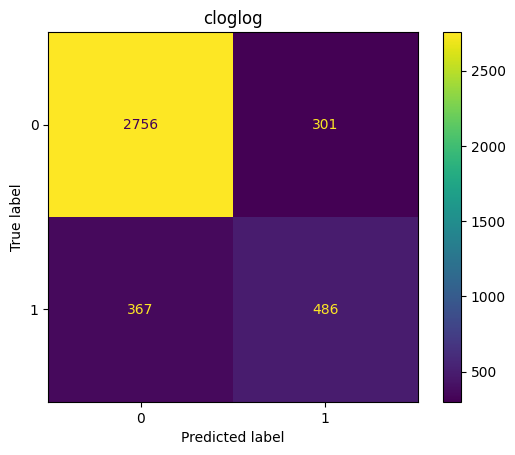

<Figure size 640x480 with 0 Axes>

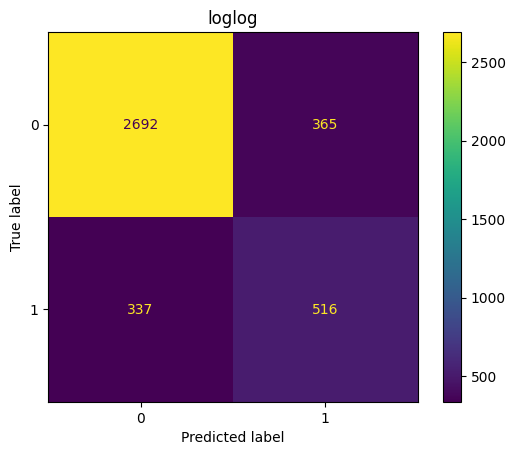

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The cloglog link alias is deprecated. Use CLogLog instead. The cloglog link alias will be removed after the 0.15.0 release.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The loglog link alias is deprecated. Use LogLog instead. The loglog link alias will be removed after the 0.15.0 release.
  warnings.warn(


sensitivity 0.5287221570926143 specificity 0.9012103369316323
sensitivity 0.5791324736225087 specificity 0.8848544324501145


<Figure size 640x480 with 0 Axes>

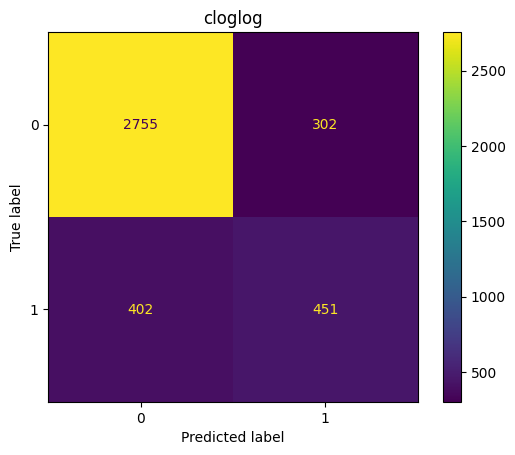

<Figure size 640x480 with 0 Axes>

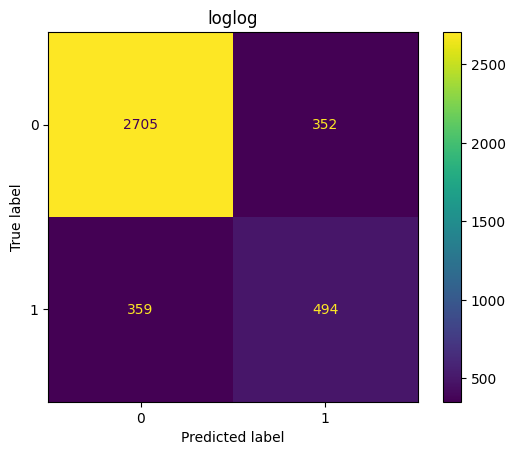

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The cloglog link alias is deprecated. Use CLogLog instead. The cloglog link alias will be removed after the 0.15.0 release.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The loglog link alias is deprecated. Use LogLog instead. The loglog link alias will be removed after the 0.15.0 release.
  warnings.warn(


sensitivity 0.5732708089097304 specificity 0.9136408243375859
sensitivity 0.6834701055099648 specificity 0.8730781812234216


<Figure size 640x480 with 0 Axes>

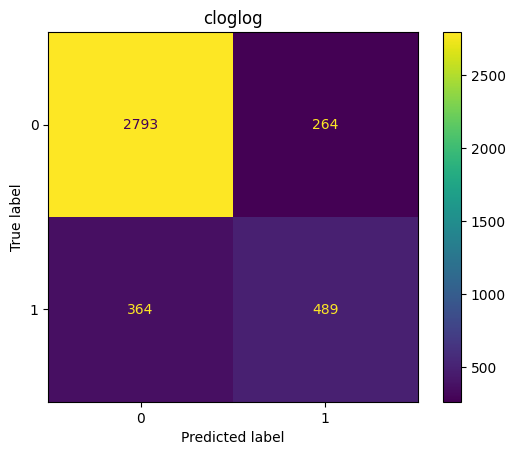

<Figure size 640x480 with 0 Axes>

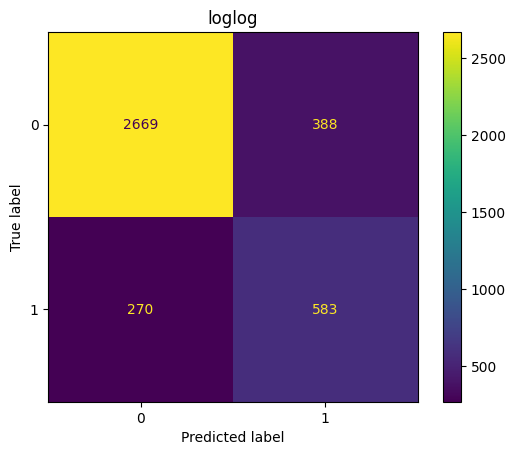

<Figure size 640x480 with 0 Axes>

In [ ]:
ajusta_todas_ligacoes(training_xsets,training_ysets, validation_xsets, validation_ysets,test_xsets,
  test_ysets, '/content/drive/MyDrive/remake_projeto_credito/todas_variaveis')

Building...



Building: 28.2s, done.Messages from stanc:
Warning in '/tmp/httpstan_lwl6isqu/model_n453cwqm.stan', line 21, column 5: Parameter
    loglambda is given a uniform distribution. The uniform distribution is
    not recommended, for two reasons: (a) Except when there are logical or
    physical constraints, it is very unusual for you to be sure that a
    parameter will fall inside a specified range, and (b) The infinite
    gradient induced by a uniform density can cause difficulties for Stan's
    sampling algorithm. As a consequence, we recommend soft constraints
    rather than hard constraints; for example, instead of giving an
    elasticity parameter a uniform(0,1) distribution, try normal(0.5,0.5).
Warning in '/tmp/httpstan_lwl6isqu/model_n453cwqm.stan', line 20, column 23: Argument
    100 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/2200)
Sampling:   0% (2/2200)
Sam

Foi ajustado o modelo 1


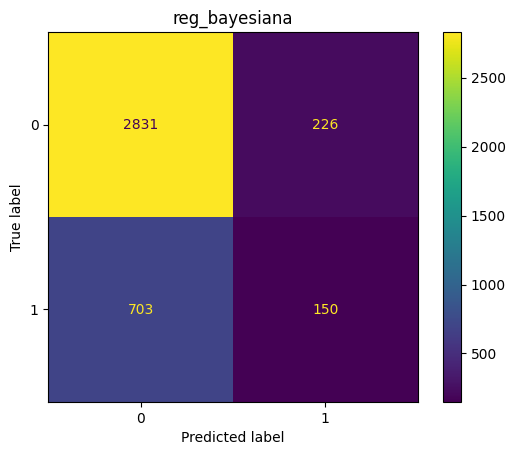

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_lwl6isqu/model_n453cwqm.stan', line 21, column 5: Parameter
    loglambda is given a uniform distribution. The uniform distribution is
    not recommended, for two reasons: (a) Except when there are logical or
    physical constraints, it is very unusual for you to be sure that a
    parameter will fall inside a specified range, and (b) The infinite
    gradient induced by a uniform density can cause difficulties for Stan's
    sampling algorithm. As a consequence, we recommend soft constraints
    rather than hard constraints; for example, instead of giving an
    elasticity parameter a uniform(0,1) distribution, try normal(0.5,0.5).
Warning in '/tmp/httpstan_lwl6isqu/model_n453cwqm.stan', line 20, column 23: Argument
    100 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/2200)
Sampling:   0% (2/

Foi ajustado o modelo 2


<Figure size 640x480 with 0 Axes>

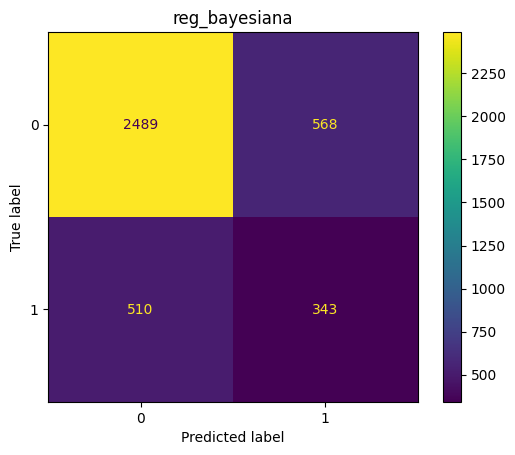

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_lwl6isqu/model_n453cwqm.stan', line 21, column 5: Parameter
    loglambda is given a uniform distribution. The uniform distribution is
    not recommended, for two reasons: (a) Except when there are logical or
    physical constraints, it is very unusual for you to be sure that a
    parameter will fall inside a specified range, and (b) The infinite
    gradient induced by a uniform density can cause difficulties for Stan's
    sampling algorithm. As a consequence, we recommend soft constraints
    rather than hard constraints; for example, instead of giving an
    elasticity parameter a uniform(0,1) distribution, try normal(0.5,0.5).
Warning in '/tmp/httpstan_lwl6isqu/model_n453cwqm.stan', line 20, column 23: Argument
    100 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/2200)
Sampling:   0% (2/

Foi ajustado o modelo 3


<Figure size 640x480 with 0 Axes>

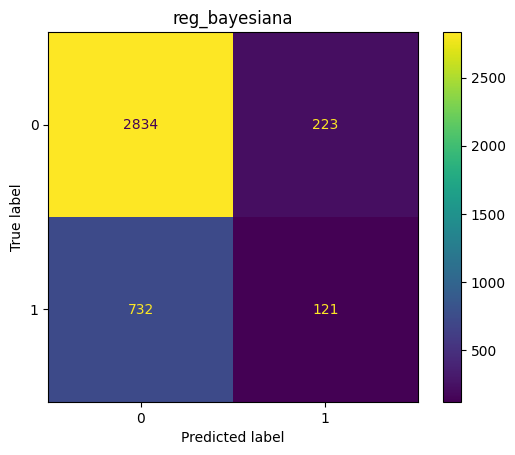

<Figure size 640x480 with 0 Axes>

In [ ]:
ajusta_regressao_bayesiana(training_xsets,training_ysets, validation_xsets, validation_ysets,test_xsets,
  test_ysets, '/content/drive/MyDrive/remake_projeto_credito/todas_variaveis')

 foi linha 1
foi linha 2 
 foi linha 1
foi linha 2
optimizou
fez prediçao
{'hat_thr':               0 modelos
KS     0.697052      rf
F1     0.799451      rf
G_M    0.823171      rf
KAPPA  0.755219      rf
MCC    0.772371      rf}
problema na matriz c



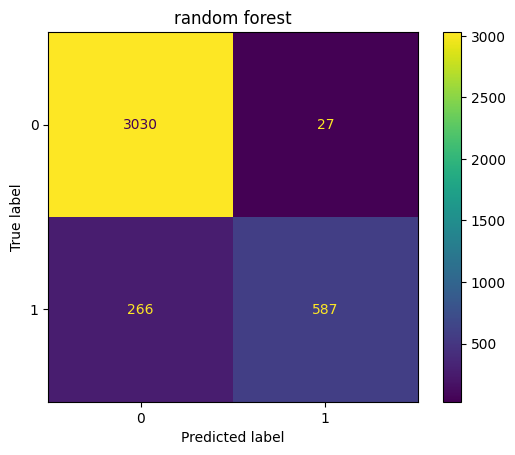

<Figure size 640x480 with 0 Axes>

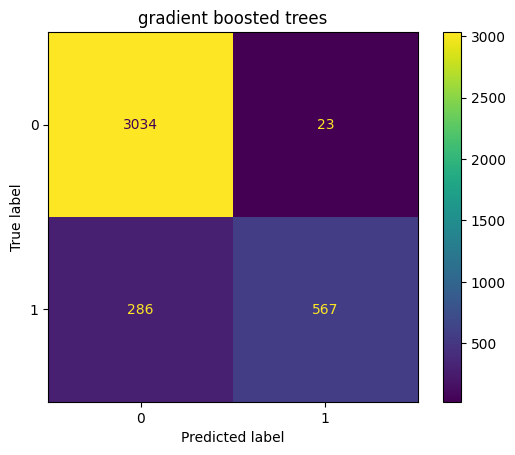

 foi linha 1
foi linha 2 
 foi linha 1
foi linha 2
optimizou
fez prediçao
{'hat_thr':               0 modelos
KS     0.695577      rf
F1     0.803224      rf
G_M    0.832070      rf
KAPPA  0.758152      rf
MCC    0.770614      rf}
problema na matriz c



<Figure size 640x480 with 0 Axes>

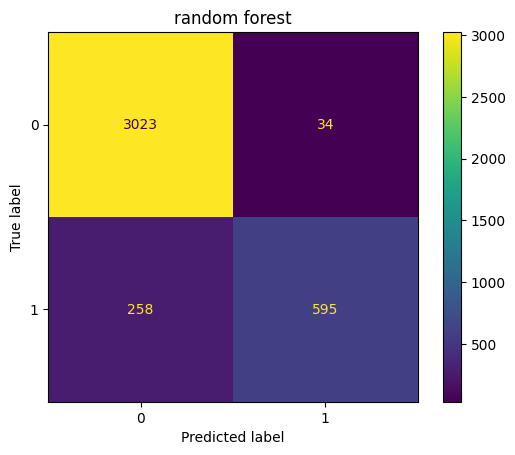

<Figure size 640x480 with 0 Axes>

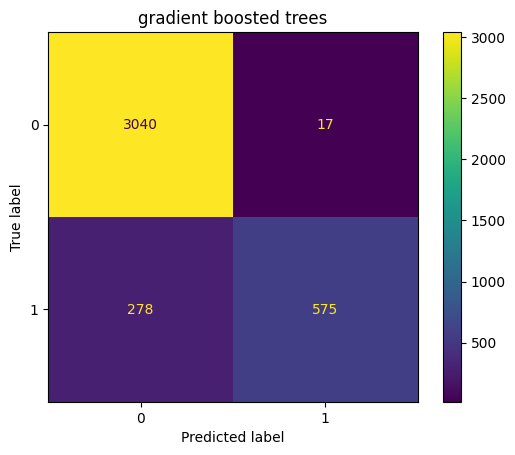

 foi linha 1
foi linha 2 
 foi linha 1
foi linha 2
optimizou
fez prediçao
{'hat_thr':               0 modelos
KS     0.733096      rf
F1     0.826987      rf
G_M    0.848375      rf
KAPPA  0.787009      rf
MCC    0.798897      rf}
problema na matriz c



<Figure size 640x480 with 0 Axes>

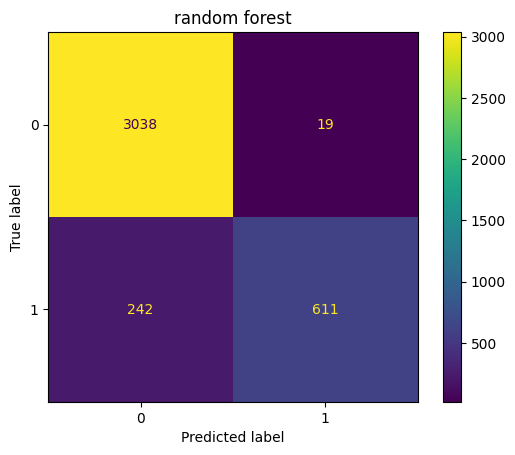

<Figure size 640x480 with 0 Axes>

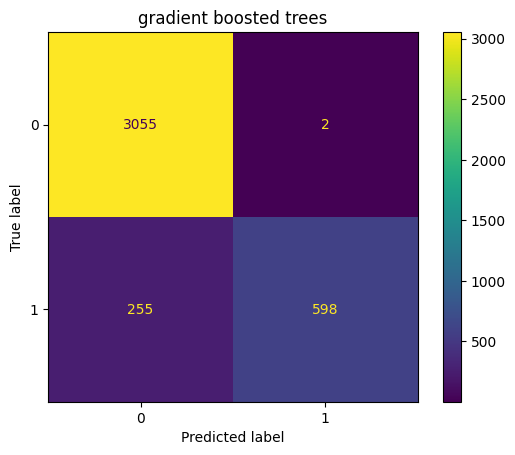

<Figure size 640x480 with 0 Axes>

In [ ]:
ajusta_modelos_ensemble(training_xsets,training_ysets, validation_xsets, validation_ysets,test_xsets,
  test_ysets, '/content/drive/MyDrive/remake_projeto_credito/todas_variaveis')

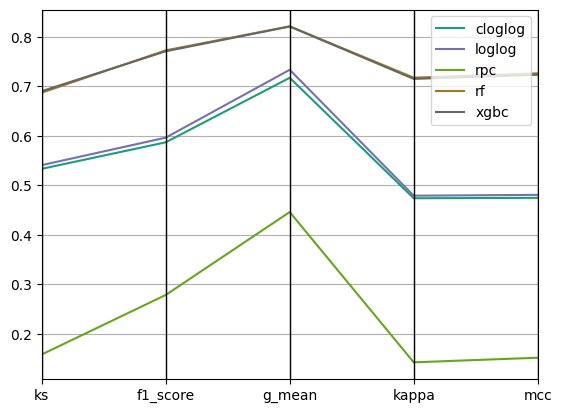

In [ ]:
# pegar a media
def calculate_mean(data):

    result = {}

    for key, tables in data.items():

      tables_f = []

      if key == 'ligs':

        for table in data[key]:
          table = table['hat_thr']
          tables_f.append(table)
        concatenated = pd.concat(tables_f)
        concatenated = concatenated.groupby(concatenated.modelos).mean()
        result[key] = concatenated

      else:

        for table in tables:

          table = table['hat_thr'].T
          table['modelos'] = key
          table = table.drop(index='modelos',axis=0)
          tables_f.append(table)

        concatenated = pd.concat(tables_f)
        concatenated = concatenated.groupby(concatenated.modelos).mean()
        result[key] = concatenated

    return result

def gera_grafico(resultado_medio):

  plot_final = []

  for key, values in resultado_medio.items():
    values.columns = ['ks',	'f1_score',	'g_mean',	'kappa',	'mcc'	]
    plot_final.append(values)

  plotar = pd.concat(plot_final, axis=0).reset_index()

  parallel_coordinates(plotar, 'modelos', colormap=cmap )
  plt.show()

metricas_todos_modelos = load_from_pickle('/content/drive/MyDrive/remake_projeto_credito/todas_variaveis/metricas_modelos.pkl')
resultado = calculate_mean( metricas_todos_modelos )
gera_grafico(resultado)

#### O treino do modelo bayesiano foi o mais demorado, mas valeu a tentativa pois ele possui propriedades preditivas e alem disso possue propriedades inferenciais muito interessantes e uma interpretação mais fácil do que o modelo de inferência clássica. Entretando como ele demorou muito tempo para ser treinado, e não teve um performance muito legal irei prosseguir com os modelos de inferência clássica e ensemble. Para melhorar a performance do modelo bayesiano poderíamos modificar os hiperparâmetros do modelo e das amostras MCMC geradas, mas isso demoraria muito tempo, como não estou com tempo prossiguirei com os outros modelos.

#### Agora vamos testar removendo as features menos importantes.

In [ ]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'person_age', 'person_income',
       'person_home_ownership', 'person_emp_length', 'loan_intent',
       'loan_grade', 'loan_amnt', 'loan_int_rate', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length',
       'loan_status'],
      dtype='object')

In [ ]:
y = df['loan_status']
X = df.drop( columns = ['loan_status', 'Unnamed: 0.1', 'Unnamed: 0' ], axis = 1 )
dropar = ['person_age', 'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT',
                        'loan_intent_PERSONAL', 'loan_intent_MEDICAL', 'loan_intent_VENTURE',
                        'cb_person_cred_hist_length', 'person_emp_length',
                        'loan_intent_DEBTCONSOLIDATION' ]

In [ ]:
training_xsets, training_ysets, validation_xsets, validation_ysets, test_xsets, test_ysets = gera_conjuntos_folds(X,
 y, skf, '/content/drive/MyDrive/remake_projeto_credito/test_feature_selection', dropar)

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The cloglog link alias is deprecated. Use CLogLog instead. The cloglog link alias will be removed after the 0.15.0 release.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The loglog link alias is deprecated. Use LogLog instead. The loglog link alias will be removed after the 0.15.0 release.
  warnings.warn(


sensitivity 0.5978898007033998 specificity 0.8577036310107949
sensitivity 0.6694021101992966 specificity 0.8298985933922146


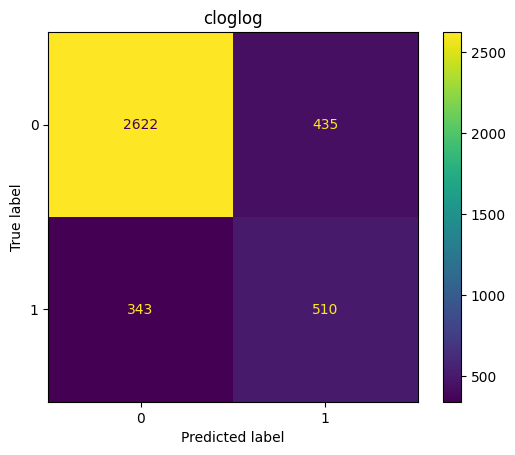

<Figure size 640x480 with 0 Axes>

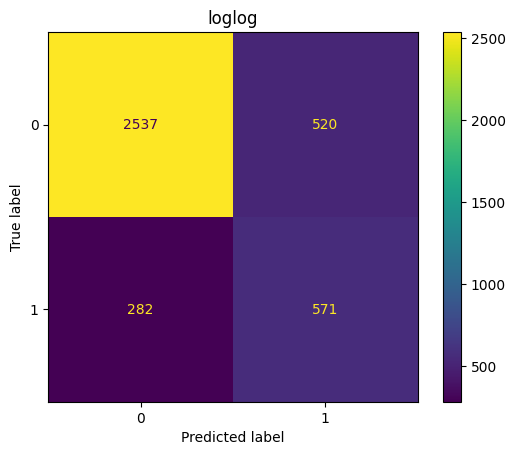

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The cloglog link alias is deprecated. Use CLogLog instead. The cloglog link alias will be removed after the 0.15.0 release.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The loglog link alias is deprecated. Use LogLog instead. The loglog link alias will be removed after the 0.15.0 release.
  warnings.warn(


sensitivity 0.5463071512309496 specificity 0.9018645731108931
sensitivity 0.5744431418522861 specificity 0.8815832515538109


<Figure size 640x480 with 0 Axes>

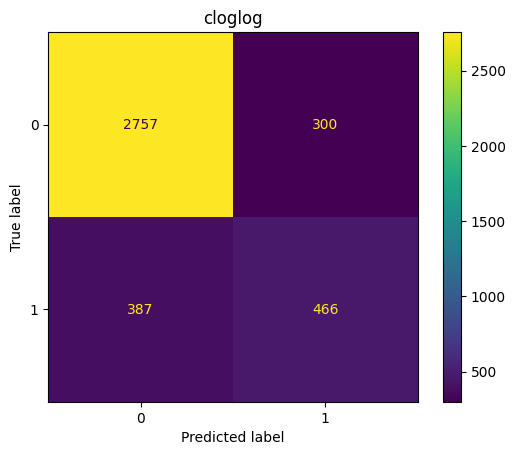

<Figure size 640x480 with 0 Axes>

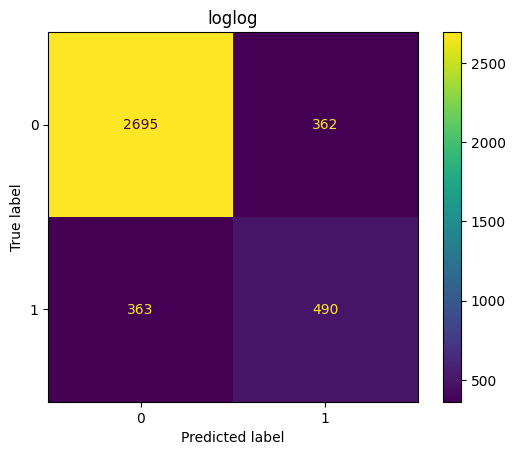

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The cloglog link alias is deprecated. Use CLogLog instead. The cloglog link alias will be removed after the 0.15.0 release.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The loglog link alias is deprecated. Use LogLog instead. The loglog link alias will be removed after the 0.15.0 release.
  warnings.warn(


sensitivity 0.6154747948417351 specificity 0.8946679751390252
sensitivity 0.6049237983587339 specificity 0.9018645731108931


<Figure size 640x480 with 0 Axes>

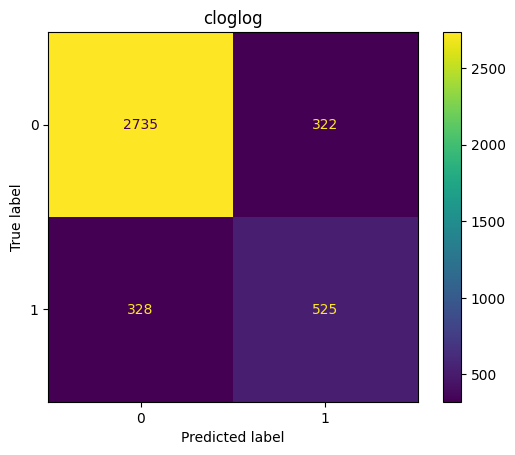

<Figure size 640x480 with 0 Axes>

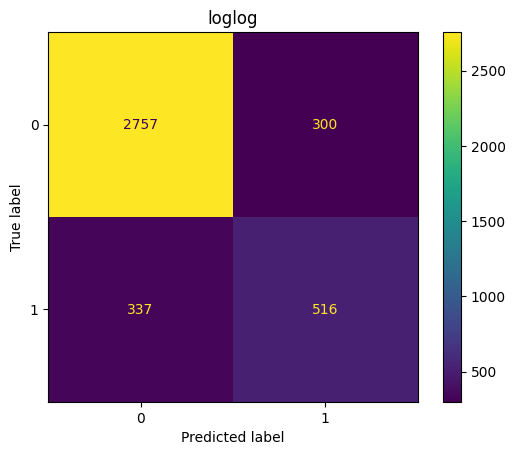

<Figure size 640x480 with 0 Axes>

In [ ]:
ajusta_todas_ligacoes(training_xsets,training_ysets, validation_xsets, validation_ysets,test_xsets,
  test_ysets, '/content/drive/MyDrive/remake_projeto_credito/test_feature_selection')

In [ ]:
ajusta_regressao_bayesiana(training_xsets,training_ysets, validation_xsets, validation_ysets,test_xsets,
  test_ysets, '/content/drive/MyDrive/remake_projeto_credito/test_feature_selection')

 foi linha 1
foi linha 2 
 foi linha 1
foi linha 2
optimizou
fez prediçao
problema na matriz c



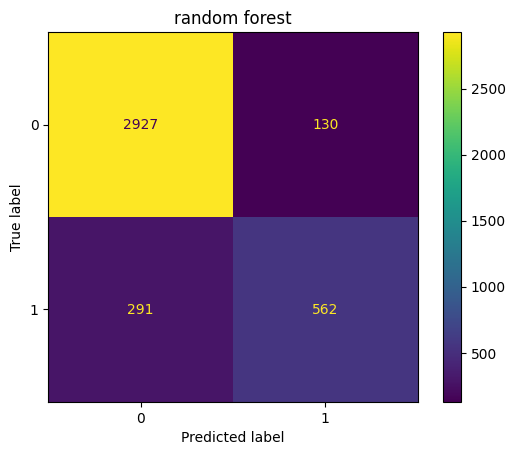

<Figure size 640x480 with 0 Axes>

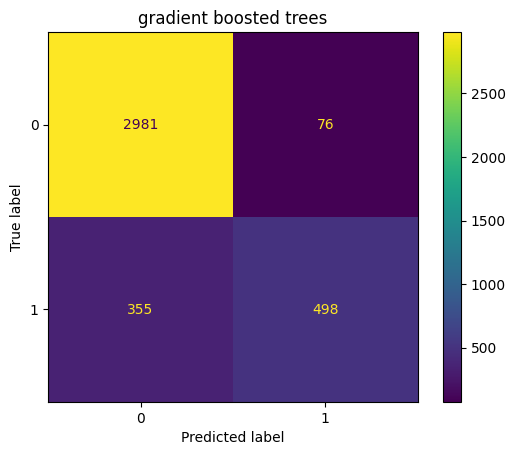

 foi linha 1
foi linha 2 
 foi linha 1
foi linha 2
optimizou
fez prediçao
problema na matriz c



<Figure size 640x480 with 0 Axes>

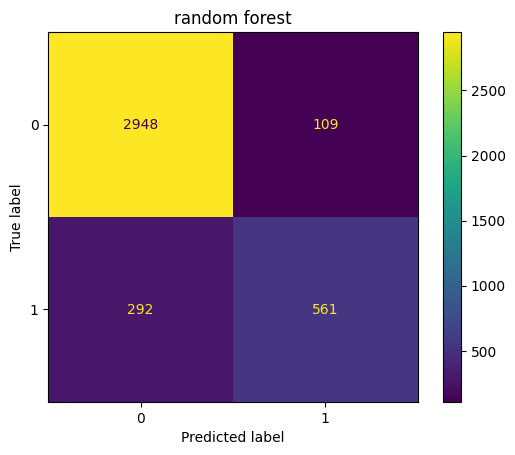

<Figure size 640x480 with 0 Axes>

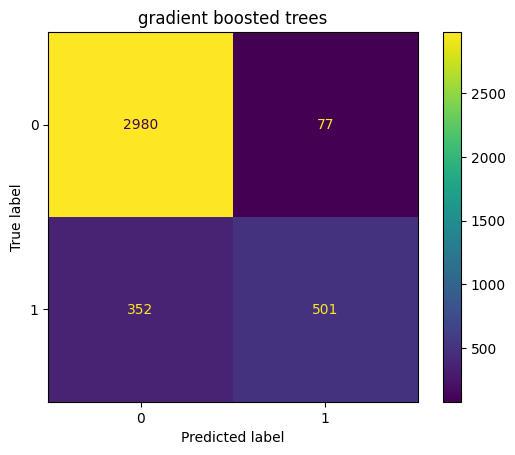

 foi linha 1
foi linha 2 
 foi linha 1
foi linha 2
optimizou
fez prediçao
problema na matriz c



<Figure size 640x480 with 0 Axes>

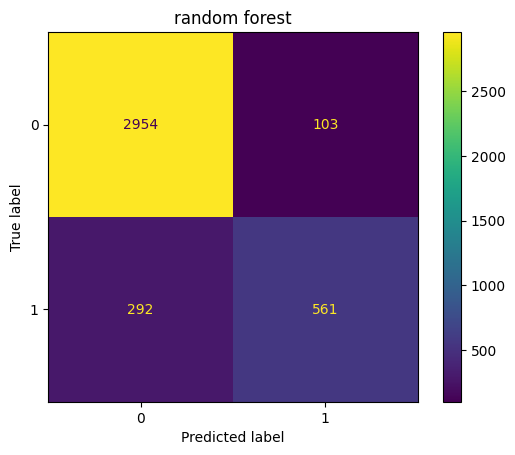

<Figure size 640x480 with 0 Axes>

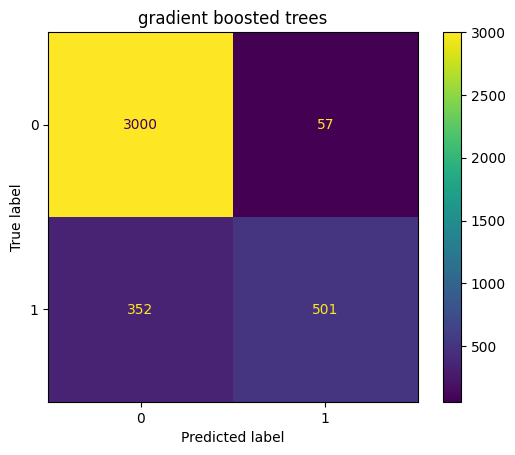

<Figure size 640x480 with 0 Axes>

In [ ]:
ajusta_modelos_ensemble(training_xsets,training_ysets, validation_xsets, validation_ysets,test_xsets,
  test_ysets, '/content/drive/MyDrive/remake_projeto_credito/test_feature_selection')

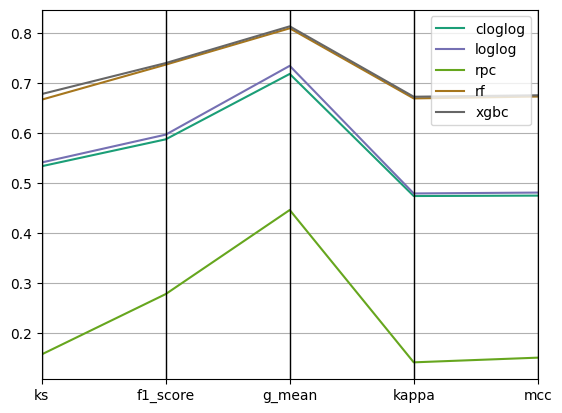

In [ ]:
metricas_todos_modelos = load_from_pickle('/content/drive/MyDrive/remake_projeto_credito/test_feature_selection/metricas_modelos.pkl')
resultado = calculate_mean( metricas_todos_modelos )
gera_grafico(resultado)

#### Podemos observar que não tivemos nenhuma mudança radical ao remover essas variáveis, pelo princípio da parsimônia seria aconselhável que o modelo final siga o padrão de remover as variáveis menos influentes. Segundo as métricas de avaliação dos modelos seria aconselhável usar o gradient boosted trees ou o random forest já que apresentam performance similar.

In [ ]:
import os
import copy

arquivos = os.listdir('/content/drive/MyDrive/remake_projeto_credito/test_feature_selection')
cms = []
indice = 0
for aq in arquivos:

  arq = copy.copy(aq)
  arq = arq.split("_")


  if 'cm'==arq[0] and ".pkl" in arq[-1] :
    indice = arquivos.index(aq)
    cms.append(arquivos[indice])

  elif indice > len(arquivos)-1:
    indice = indice - 1

cms

['cm_ligacao_cloglog1.pkl',
 'cm_ligacao_cloglog2.pkl',
 'cm_ligacao_cloglog3.pkl',
 'cm_ligacao_loglog1.pkl',
 'cm_ligacao_loglog2.pkl',
 'cm_ligacao_loglog3.pkl',
 'cm_rf_1.pkl',
 'cm_rf_2.pkl',
 'cm_rf_3.pkl',
 'cm_xgb_1.pkl',
 'cm_xgb_2.pkl',
 'cm_xgb_3.pkl']

In [ ]:
def porcentagem_classes( cm):

  TP = cm[1][1]
  FP = cm[0][1]
  FN = cm[1][0]
  TN = cm[0][0]

  TPR = TP/(TP+TN+FN+FP)
  TNR = TN/(TP+TN+FN+FP)
  FNR = FN/(TP+TN+FN+FP)
  FPR = FP/(TP+TN+FN+FP)

  return TPR,TNR,FNR,FPR

In [ ]:
def estimativa_faturamento_gasto_lucro(cm, N, lucro_medio_cliente, gasto_inadimplente, faturamento_medio_cliente_n_inad ):

    TPR,TNR,FNR,FPR = porcentagem_classes(cm)

    inadimplentes_gasto = (FNR*N)*gasto_inadimplente
    n_inadimplente_gasto = (FPR*N)*lucro_medio_cliente
    gasto = inadimplentes_gasto + n_inadimplente_gasto

    lucro_nao_inad = (TNR*N)*(lucro_medio_cliente)
    faturamento_n_inad = (TNR*N)*(faturamento_medio_cliente_n_inad)

    return faturamento_n_inad, lucro_nao_inad, gasto

No momento da classificação vamos considerar que um falso positivo cause um gasto igual a média de lucro por cliente igual a R$1086.18.
Um Falso negativo causa o gasto de um inadimplente, pois é um inadimplente R$10682
O bom pagador causa um lucro de 1086.18
e um verdadeiro negativo não causa gasto nenhum nem lucro nenhum.

In [ ]:
cms

['cm_ligacao_cloglog1.pkl',
 'cm_ligacao_cloglog2.pkl',
 'cm_ligacao_cloglog3.pkl',
 'cm_ligacao_loglog1.pkl',
 'cm_ligacao_loglog2.pkl',
 'cm_ligacao_loglog3.pkl',
 'cm_rf_1.pkl',
 'cm_rf_2.pkl',
 'cm_rf_3.pkl',
 'cm_xgb_1.pkl',
 'cm_xgb_2.pkl',
 'cm_xgb_3.pkl']

In [ ]:
for cm in cms:
    print(cm)
    cm = load_from_pickle(f'/content/drive/MyDrive/remake_projeto_credito/test_feature_selection/{cm}')
    print(porcentagem_classes(cm))

cm_ligacao_cloglog1.pkl
(np.float64(0.13043478260869565), np.float64(0.6705882352941176), np.float64(0.08772378516624041), np.float64(0.11125319693094629))
cm_ligacao_cloglog2.pkl
(np.float64(0.11918158567774936), np.float64(0.7051150895140665), np.float64(0.0989769820971867), np.float64(0.07672634271099744))
cm_ligacao_cloglog3.pkl
(np.float64(0.13427109974424553), np.float64(0.6994884910485933), np.float64(0.08388746803069054), np.float64(0.08235294117647059))
cm_ligacao_loglog1.pkl
(np.float64(0.14603580562659846), np.float64(0.648849104859335), np.float64(0.0721227621483376), np.float64(0.1329923273657289))
cm_ligacao_loglog2.pkl
(np.float64(0.12531969309462915), np.float64(0.6892583120204604), np.float64(0.09283887468030691), np.float64(0.09258312020460358))
cm_ligacao_loglog3.pkl
(np.float64(0.1319693094629156), np.float64(0.7051150895140665), np.float64(0.08618925831202046), np.float64(0.07672634271099744))
cm_rf_1.pkl
(np.float64(0.14373401534526853), np.float64(0.7485933503836

In [ ]:
import pandas as pd

faturamento_gasto = pd.DataFrame()
linha = 0
N = 19548 # df.shape[0]

for i in cms:
  cm = load_from_pickle(f'/content/drive/MyDrive/remake_projeto_credito/test_feature_selection/{i}')
  print(cm)
  #faturamento, gasto = calcula_faturamento_gastos(cm, lucro_medio_cliente, gasto_inadimplente, media_emprestimo )
  faturamento_n_inad, lucro, gasto = estimativa_faturamento_gasto_lucro(cm, N,lucro_medio_cliente_n_inad, gasto_inadimplente, faturamento_medio_cliente_n_inad )
  print(i)
  print("faturamento",faturamento_n_inad,"gasto", gasto)
  print( " o lucro foi de faturamento - gasto =", faturamento_n_inad-gasto )
  faturamento_gasto.at[linha, 'modelo_fold'] = i
  faturamento_gasto.at[linha, 'faturamento'] = faturamento_n_inad
  faturamento_gasto.at[linha, 'gasto'] = gasto
  faturamento_gasto.at[linha, 'lucro'] = faturamento_n_inad - gasto
  linha = linha + 1

[[2622  435]
 [ 343  510]]
cm_ligacao_cloglog1.pkl
faturamento 134115563.11495274 gasto 4614841.218551242
 o lucro foi de faturamento - gasto = 129500721.8964015
[[2757  300]
 [ 387  466]]
cm_ligacao_cloglog2.pkl
faturamento 141020826.6620613 gasto 4263370.332864013
 o lucro foi de faturamento - gasto = 136757456.3291973
[[2735  322]
 [ 328  525]]
cm_ligacao_cloglog3.pkl
faturamento 139895524.45438436 gasto 3948337.1840880257
 o lucro foi de faturamento - gasto = 135947187.27029634
[[2537  520]
 [ 282  571]]
cm_ligacao_loglog1.pkl
faturamento 129767804.58529182 gasto 4596959.063253419
 o lucro foi de faturamento - gasto = 125170845.5220384
[[2695  362]
 [ 363  490]]
cm_ligacao_loglog2.pkl
faturamento 137849520.4404263 gasto 4397543.106913995
 o lucro foi de faturamento - gasto = 133451977.33351229
[[2757  300]
 [ 337  516]]
cm_ligacao_loglog3.pkl
faturamento 141020826.6620613 gasto 3904203.3000651184
 o lucro foi de faturamento - gasto = 137116623.36199617
[[2927  130]
 [ 291  562]]
cm

In [ ]:
faturamento_gasto.sort_values(by='lucro', ascending=False).style.bar(color='darkblue')

,modelo_fold,faturamento,gasto,lucro
11,cm_xgb_3.pkl,153450301.046857,2810385.235714,150639915.811142
9,cm_xgb_1.pkl,152478449.140227,2925885.032619,149552564.107608
10,cm_xgb_2.pkl,152427299.039878,2909279.735648,149518019.304230
8,cm_rf_3.pkl,151097396.430805,2606842.146202,148490554.284602
7,cm_rf_2.pkl,150790495.828711,2636510.496182,148153985.332529
6,cm_rf_1.pkl,149716343.721383,2733166.380456,146983177.340927
5,cm_ligacao_loglog3.pkl,141020826.662061,3904203.300065,137116623.361996
1,cm_ligacao_cloglog2.pkl,141020826.662061,4263370.332864,136757456.329197
2,cm_ligacao_cloglog3.pkl,139895524.454384,3948337.184088,135947187.270296
4,cm_ligacao_loglog2.pkl,137849520.440426,4397543.106914,133451977.333512


Considerando que o lucro final seja o faturamento menos o gasto(quantidade do empréstimo inadimplentes X taxa empréstimos + quantidade do empréstimo dos não inadimplentes, ou seja o custo total) seja igual ao lucro final, temos que o aumento no lucro do caso onde não utilizamos o modelo e no caso que utilizamos o modelo é:

In [ ]:
def calcula_lucro_final( lucro1, lucro2):
    return ((lucro2 - lucro1)/abs(lucro1) )*100

lucro_sem_modelo = 156361392.77701938 - 193688429.71052217
lucro_com_modelo = 153450301.046857	- 2810385.235714
print('aumento no lucro final utilizando o modelo : ',  calcula_lucro_final( lucro_sem_modelo,
lucro_com_modelo), '%')

aumento no lucro final utilizando o modelo :  503.56783764943447 %


In [ ]:
156361392.77701938 - 193688429.71052217

-37327036.93350279

In [ ]:
lucro_com_modelo

150639915.811143

### Ou seja, utilizando o modelo tivemos um aumento percentual de mais de 503% nos lucros, o que em números brutos representa: R$150.639.915.
###  e no caso onde não estavamos usando o modelo estavamos tendo um prejuízo no final das contas ao invés de lucro de menos R$37.327.036

#### E olhando do ponto de vista de redução de gastos

In [ ]:
reducao_gastos = 193688429.71052217 - 2810385.235714
print( 'Redução nos gastos ao utilizar o modelo em R$',
 round(reducao_gastos) )

Redução nos gastos ao utilizar o modelo em R$ 190878044


#### Ou seja, economizamos aproximadamente R$190.878.044 milhões de reais ao utilizar o modelo.

#### Sobre a análise poderíamos fazer mais alguns experimentos, aplicar o weight of evidence (WOE) nas variáveis categóricas para verificar se modifica a performance do modelo, remover mais features, ajustar outros modelos, entre outros.